**CodeQA: Advanced Programming
Question-Answering using LLM Agent and RAG**

### **Our Team 🤝**

- **[Mostafa Samer Dorrah](https://www.linkedin.com/in/mostafadorrah)**
- **[Mohamed Ahmed Mohamed](https://www.linkedin.com/in/mohamed-ahmed-91a4a4219)**
- **[Ahmed Ashraf](https://www.linkedin.com/in/ahmed-ashraf-a03684149/)**
- **[Abdelrahman Elatrozy](https://www.linkedin.com/in/abdelrahman-elatrozy-359514311)**
- **[Bahaa Eldin Moustafa](https://www.linkedin.com/in/bahaa-eldin-moustafa-aa15a11b8)**
- **[Yousif Adel Khalil](https://www.linkedin.com/in/yousef-a-khalil/)**






---








# **Our main goal and strategies ⛓️**

**Main Idea**

In this notebook, we will explore ways to improve the model's ability to answer coding questions with up-to-date information. We will compare the Traditional ways of using vector databases and transformer models vs Creating an LLM agent that can use different tools to update its information before answering. We currently are using Python for our comparison but in future work, we intend to add more languages and frameworks.


**Traditional ways pipeline**

To achieve high accuracy with the traditional ways we decided that the best approach would be to build a rag system using the up-to-date programming language documentation. We used the current stable version 3.12.3 provided in the official [python documentation](https://docs.python.org/3/). After cleaning the data we used semantic chunking to chunk the documentation into meaningful chunks then we compared 2 vector databases Chroma DB(HNSW) and Milvus(IVF PQ). After building our Rag system we then used it to retrieve the top-related context and then send it along with the question to the transformer model, we decided to use the [google flan-t5-base](https://huggingface.co/google/flan-t5-base).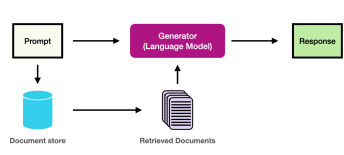


**LLM Agent pipeline**

In the Agent pipeline, we First take in the question and give it to a Router node that determines if it is a Python question or an unrelated question, if it is a python related question it goes to the retriever node where it retrieves the related context from the vector database it then goes to the grade document node were it gets graded if it is related to the question or not, if we go to the web search node that searches for recent context in the web. and finally, the context and the question go to the generation node to generate the answer. after the answer is generated it goes to the grade generation node where it grades the generated answer and decides to do another web search or end with the final answer. 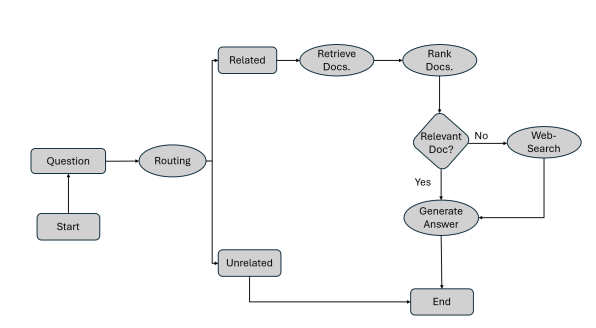



---



In [1]:
#only in colab

!pip -q install langchain langchain-community langchain_experimental langchain_groq langgraph
!pip -q install chromadb
!pip -q install sentence_transformers
!pip install pymilvus
!pip install -q accelerate==0.27.2 peft==0.8.2 bitsandbytes==0.41.3 transformers==4.33.1 trl==0.4.7
!pip install 'transformers @ git+https://github.com/huggingface/transformers.git@831bc25d8fdb85768402f772cf65cc3d7872b211'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
Milvus_url = userdata.get('MILVUS_SERVER_URL')
Milvus_token = userdata.get('MILVUS_SERVER_TOKEN')

# Importing main libraries 📚

In [5]:
import os
import torch
from typing import List
from langchain import hub
from langchain_groq import ChatGroq
from peft import LoraConfig, PeftModel
from typing_extensions import TypedDict
from langchain import HuggingFacePipeline
from langchain.vectorstores import Chroma
from pymilvus import MilvusClient, DataType
from langgraph.graph import END, StateGraph
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain.docstore.document import Document
from langchain.output_parsers import ResponseSchema,StructuredOutputParser

from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain.document_loaders import TextLoader,DirectoryLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from transformers import (AutoModelForCausalLM,AutoModelForSeq2SeqLM,LlamaForCausalLM,AutoTokenizer,BitsAndBytesConfig,HfArgumentParser,TrainingArguments,pipeline,logging)

# Transformers pipeline 🤖

## Building the RAG system

In [6]:
model_name = "all-mpnet-base-v2"
encode_kwargs = {'normalize_embeddings': True}

model_norm = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs=encode_kwargs
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
loader = DirectoryLoader('/content/drive/MyDrive/cleaned_files_2/', glob="./*.txt", loader_cls=TextLoader)

documents = loader.load()

In [8]:
text_splitter = SemanticChunker(model_norm, breakpoint_threshold_type="standard_deviation")
docx = text_splitter.create_documents([d.page_content for d in documents])

### ChromaDB vs Milvus



<img src="Feb_05_Chroma_vs_Milvus_20240202_024325_1633ccfc67.png" width="300" height="300">



#### ChromaDB

In [9]:
ChromaDB = Chroma.from_documents(documents=docx,
                                 embedding=model_norm,
                                 persist_directory='db')

#### Milvus

##### Building the Milvus collection

In [10]:
embeddings = model_norm.embed_documents([d.page_content for d in docx])

In [ ]:
len(embeddings[0])

768

In [ ]:
client = MilvusClient(
    uri=Milvus_url,
    token =Milvus_token
)

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 60014ee9f056422591f4c1568ddec842


In [ ]:
data = []
for i in range (0 , len(embeddings)):
  data.append({"id": i, "vector": embeddings[i], "page_content":docx[i].page_content})

In [10]:
collection_name = 'NLP_Project'

index_params = client.prepare_index_params()

index_params.add_index(
    field_name="id",
    index_type="STL_SORT"
)

index_params.add_index(
    field_name="vector",
    index_type="IVF_PQ",
    metric_type="COSINE",
    params={ "nlist": 200 }
)

client.create_collection(
    collection_name=collection_name,
    index_params=index_params,
    dimension=768
)

res = client.get_load_state(
    collection_name=collection_name
)

res = client.insert(
    collection_name=collection_name,
    data=data
)


##### Milvus search

In [11]:
client = MilvusClient(
    uri=Milvus_url,
    token =Milvus_token
)

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 9dc4f6bcc50d4329ac5a7019829f9c2f


In [12]:
query_vectors = model_norm.embed_query("data and time function")

res = client.search(
    collection_name="NLP_Project",
    data=[query_vectors],
    limit=3,
    output_fields=['page_content','id']
)
print(res[0][1]["entity"]["page_content"])

datetime — Basic date and time types — Python 3.12.3 documentation
 |
datetime — Basic date and time types¶
Source code: Lib/datetime.py
The datetime module supplies classes for manipulating dates and times. While date and time arithmetic is supported, the focus of the implementation is
on efficient attribute extraction for output formatting and manipulation. Tip
Skip to the format codes. See also
Module calendarGeneral calendar related functions. Module timeTime access and conversions. Module zoneinfoConcrete time zones representing the IANA time zone database. Package dateutilThird-party library with expanded time zone and parsing support. Package DateTypeThird-party library that introduces distinct static types to e.g. allow
static type checkers
to differentiate between naive and aware datetimes. Aware and Naive Objects¶
Date and time objects may be categorized as “aware” or “naive” depending on
whether or not they include timezone information. With sufficient knowledge of applicabl

### Transformer pipeline

In [13]:
tokenizer_t5 = AutoTokenizer.from_pretrained("google/flan-t5-large",truncate = True)
T5_flan = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
T5_flan_pipe = pipeline("text2text-generation", model=T5_flan, tokenizer=tokenizer_t5, max_new_tokens = 512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [14]:
def RAG_Milvus(question):
  query_vectors = model_norm.embed_query(question)

  res = client.search(
      collection_name="NLP_Project",
      data=[query_vectors],
      limit=2,
      output_fields=['page_content','id']
  )

  output = res[0][0]["entity"]["page_content"] +" "+ res[0][1]["entity"]["page_content"]
  return output


def RAG_Chroma(question):

  ChromaDB.similarity_search_by_vector(query_vectors)

  output = res[0][0]["entity"]["page_content"] +" "+ res[0][1]["entity"]["page_content"]
  return output


def predict_Transformer(question,RAG):

  context = RAG(question)

  template = f"""You are an assistant for Code related question answering tasks.Use the following pieces of retrieved context to write your answer. If you don't know the answer, just say that you don't know.
  write a running code in pyhton.
  context: {context}
  Question: {question}
  Helpful Answer:"""

  output = T5_flan_pipe(template)[0]["generated_text"]

  return output

# LLM and Agents Pipeline

Llama 70b api

In [15]:
llama_70b = ChatGroq(model="llama3-70b-8192",temperature=0)

## DB Retrieval Grader

In [16]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llama_70b | JsonOutputParser()

## Hallucination Grader

In [17]:
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llama_70b | JsonOutputParser()

## Generator Answer Grader

In [18]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llama_70b | JsonOutputParser()

## Main Router

In [19]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
    user question to a vectorstore or web search. Use the vectorstore for questions on python,
    write code and make algorithm. You do not need to be stringent with the keywords
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explaination. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llama_70b | JsonOutputParser()

### Loading the model

In [20]:
model_name = "NousResearch/Llama-2-7b-chat-hf"
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False
device_map = {"": 0}

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

## Answer Generator

In [21]:
pipe = pipeline(task="text-generation",
               model=model,
               tokenizer=tokenizer,
                max_new_tokens = 4000,
                do_sample = True,
                temperature = 0.1,
               )


In [22]:
prompt = PromptTemplate(
    template=""" You are an assistant for Code related question answering tasks.
    Use the following pieces of retrieved context to write your answer. If you don't know the answer, just say that you don't know.
    Context: {context}
    Question: {question}

    Answer: """,
    input_variables=["question", "context"],
)

llama_7b = HuggingFacePipeline(pipeline=pipe)

rag_chain = prompt | llama_7b | StrOutputParser()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(


##Langgraph Flow

In [23]:
execution_time_1 = 0
web_search_tool = TavilySearchResults(k=2)

class GraphState(TypedDict):

    question : str
    generation : str
    web_search : str
    num_steps : int
    documents : List[str]



# Nodes

def retrieve(state):

    print("---RETRIEVE---")
    question = state["question"]
    num_steps = int(state['num_steps'])
    num_steps += 1

    # Retrieval
    documents = RAG_Milvus(question)
    return {"documents": documents, "question": question, "num_steps":num_steps}

def grade_documents(state):

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    num_steps = int(state['num_steps'])
    num_steps += 1

    filtered_docs = []
    web_search = "No"
    score = retrieval_grader.invoke({"question": question, "document": documents})
    grade = score['score']
    # Document relevant
    if grade.lower() == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
        filtered_docs.append(documents)

    # Document not relevant
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        # We do not include the document in filtered_docs
        # We set a flag to indicate that we want to run web search
        web_search = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search": web_search, "num_steps":num_steps}

def web_search(state):

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    num_steps = int(state['num_steps'])
    num_steps += 1

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question, "num_steps":num_steps}


def route_question(state):

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def generate(state):

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    num_steps = int(state['num_steps'])
    num_steps += 1

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation, "num_steps":num_steps}


def grade_generation_v_documents_and_question(state):

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']


    num_steps = int(state['num_steps'])

    if num_steps > 5 :
      return "inLoop"
    else:
      if grade == "yes":
          print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

          # Check question-answering
          print("---GRADE GENERATION vs QUESTION---")
          score = answer_grader.invoke({"question": question,"generation": generation})
          grade = score['score']
          if grade == "yes":
              print("---DECISION: GENERATION ADDRESSES QUESTION---")
              print("\nNumber of Steps", num_steps)
              return "useful"
          else:
              print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
              return "not useful"
      else:
          print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
          return "not supported"


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

In [24]:
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")


workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")


workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "inLoop": END
    },
)

In [25]:
app = workflow.compile()

In [26]:
def predict_agent(Question):
  inputs = {"question": Question,"num_steps":0 }
  for output in app.stream(inputs):
      for key, value in output.items():
          print(f"Finished running: {key}:")
  if value["num_steps"] > 5:
    print("it get in to loop")
    value["generation"] = 'Error get in to loop'
  else:
    print(value["generation"])


# Manual Testing

In [27]:
Question = "How to implement date and time function in python"

In [28]:
%%time
predict_Transformer(Question,RAG_Milvus)

Token indices sequence length is longer than the specified maximum sequence length for this model (1696 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 46.4 s, sys: 6.85 s, total: 53.3 s
Wall time: 54 s


'Lib/datetime.py The datetime module supplies classes for manipulating dates and times. While date and time arithmetic is supported, the focus of the implementation is on efficient attribute extraction for output formatting and manipulation.'

In [29]:
%%time
predict_agent(Question)

---ROUTE QUESTION---
How to implement date and time function in python
---ROUTE QUESTION TO RAG---
---RETRIEVE---
Finished running: retrieve:
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Finished running: grade_documents:
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---

Number of Steps 3
Finished running: generate:
 You are an assistant for Code related question answering tasks.
    Use the following pieces of retrieved context to write your answer. If you don't know the answer, just say that you don't know.
    Context: ['time — Time access and conversions — Python 3.12.3 documentation\n |\ntime — Time access and conversions¶\nThis module provides various time-related functions. For related\nfunctionality, see also the datetime and calendar modules. Although this module is alwa

# Final Testing

In [ ]:
import pandas as pd
import time
df = pd.read_csv('/content/Test.csv')


In [ ]:
Final_Test = pd.DataFrame(columns=['context1','context2', 'question', 'answer1', 'answer2', 'score1', 'score2',"Time1","Time2"])

In [ ]:
for index,row in df.iterrows():
  if index >= 0:
    # Compile
    app = workflow.compile()

    # Test
    inputs = {"question": row["intent"],"num_steps":0 }
    start_1 = time.time()
    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"Finished running: {key}:")
    if value["num_steps"] > 5:
      print("it get in to loop")
      value["generation"] = 'Error get in to loop'
    else:
      print(value["generation"])

    end_1 = time.time()

    execution_time_1 = start_1 - end_1


    context1 = value["documents"]
    question = value["question"]
    answer1 = value["generation"]

    # def format_docs(docs):
    #     return "\n\n".join(doc.page_content for doc in docs)


    context2 = RAG_Milvus(question)

    start_time_2 = time.time()

    answer2 = predict_Transformer(question,RAG_Milvus)

    end_time_2 = time.time()
    execution_time_2 = end_time_2 - start_time_2



    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for Evaluate answer about code problems .
        These answers are from rag system.
        Given the question evaluate answer1 and answer2 based on Context1 and contect2. give the score out of 5
        Give the score based on how good the answer given the context <|eot_id|><|start_header_id|>user<|end_header_id|>
        Context1: {context1}
        context2: {context2}
        Question: {question}
        Answer1: {answer1}
        Answer2: {answer2}
        Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question","answer1", "answer2","context1",'context2'],
    )

    llm = ChatGroq(model="llama3-70b-8192",temperature=0)

    # Chain
    new = prompt | llm | StrOutputParser()


    generation = new.invoke({"context1": context1,"context2": context2 ,"question": question,"answer1":answer1,"answer2":answer2})


    score1 = ResponseSchema(name="score1",
                                description="It is the score for answer1\
                                you should output score from range 0 to 5")
    score2 = ResponseSchema(name="score1",
                                description="It is the score for answer2\
                                you should output score from range 0 to 5")

    response_schemas = [score1,
                        score2]



    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    format_instructions = output_parser.get_format_instructions()
    review_template_2 = """\
    For the following text, extract the following information:

    score1: The score that is given for Answer1 \
    Answer in range of 0 and 5.

    score2: The score that is given for Answer2 \
    Answer in range of 0 and 5.

    text: {text}

    {format_instructions}
    """

    prompt = ChatPromptTemplate.from_template(template=review_template_2)

    messages = prompt.format_messages(text=generation,
                                    format_instructions=format_instructions)

    chat = ChatGroq(model="llama3-70b-8192",temperature=0)
    response = chat(messages)
    output_dict = output_parser.parse(response.content)

    new_data={'context1': context1,'context2':context2, 'question': question, 'answer1': answer1, 'answer2': answer2, 'score1': output_dict['score1'], 'score2': output_dict['score2'],'Time1':execution_time_1,'Time2':execution_time_2}
    Final_Test.loc[index] = new_data

    Final_Test.to_csv("Results_NLP_Python.csv",index = False)

  # output.loc[i] = output.append({'context': full_context, 'question': question, 'answer1': answer1, 'answer2': answer2, 'score1': output_dict['score1'], 'score2': output_dict['score2']}, ignore_index=True)

# Resources and References 📚



1.   https://huggingface.co/google/flan-t5-base
2.   https://docs.python.org/3/
3.   https://youtu.be/qaWOwbFw3cs?si=xZ_8-oEA7uBgRrq6
4.   https://huggingface.co/mlc-ai/Llama-2-7b-chat-hf-q4f32_1-MLC


